# Set Cover Problem

## Useful imports

In [33]:
from random import random, seed
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
from icecream import ic
from matplotlib import pyplot as plt
import math
import random

## Initialization

In [70]:
var_UNIVERSE_SIZE = [100, 1000, 10000, 100000, 100000, 100000]
var_NUM_SETS = [10, 100, 1000, 10000, 10000, 10000]
var_DENSITY = [0.2, 0.2, 0.2, 0.1, 0.2, 0.3]
MAX_STEPS = 150
SETS = None
COSTS = None

In [71]:
def generate_sets_and_costs(universe_size, num_sets, density):
    global SETS, COSTS, rng, UNIVERSE_SIZE, NUM_SETS, DENSITY
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density
    
    rng = np.random.Generator(np.random.PCG64([universe_size, num_sets, int(10_000 * density)]))
    SETS = rng.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[rng.integers(num_sets), s] = True
    COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [66]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))



def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution): 
    """Returns the fitness of a solution"""
    return (valid(solution), -cost(solution)) 

def fitness_improved(solution):
    
    """Returns the fitness of a solution in terms of (# of covered items, -cost)"""
    covered_items = (np.sum(np.any(SETS[solution], axis=0)), -cost(solution))
    
    return covered_items


def starting_point():
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < 1
    return solution

def starting_point_2():
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < 0.001
    return solution

def plotter(history):
    c_values = [c for v, c in history]
    plt.figure(figsize=(14, 8))
    plt.plot( range(len(c_values)), list(accumulate(c_values, max)),color="red",label="- Cost (Cumulative Max)")
    _ = plt.scatter(range(len(c_values)), c_values, marker=".", label="- Cost (Each Step)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plotter2(history):
    s_values = [s for s, c in history]
    plt.figure(figsize=(14, 8))
    plt.plot( range(len(s_values)), list(accumulate(s_values, max)),color="red", label="# of Covered Items (Cumulative Max)")
    _ = plt.scatter(range(len(s_values)), s_values, marker=".", label="# of Covered Items (Each Step)")   
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.show() 

## The Funny part

### The Dumbest solution 

In [6]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_costs(universe_size, num_sets, density)
    solution = np.full(num_sets, True)
    print(f"({valid(solution)}, {cost(solution)})")

(True, 284.0492127923681)
(True, 34399.36910141707)
(True, 4274637.362898732)
(True, 251195062.11544773)
(True, 538382974.1704884)
(True, 841074268.5589321)


### The Random solution

In [51]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_costs(universe_size, num_sets, density)
    solution = rng.random(num_sets) < .5
    print(f"The solution is valid:({valid(solution)}, Cost: {cost(solution)})")

The solution is valid:(False, Cost: 81.05593172943863)
The solution is valid:(True, Cost: 15343.390857790255)
The solution is valid:(True, Cost: 2292161.920691861)
The solution is valid:(True, Cost: 125584385.28026739)
The solution is valid:(True, Cost: 272457603.0691776)
The solution is valid:(True, Cost: 424166191.6289293)


### Hill Climbing - RMHC  

First try with the Random Mutation Hill Climbing 

Dobbiamo trovare il numero di volte che l'algoritmo raggiunge la soluzione migliore


In [72]:
#Define the tweak function

def tweak_RMHC(solution):
    new_solution = solution.copy()

    activate_set = rng.random() < 0.5
    
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    
    
    while np.random.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    
    return new_solution

In [73]:
def hill_climb_RMHC(tweak, sp, f, plot):
    max_step=0
    
    solution = sp()

    best_solution = solution
    best_fitness = f(solution)
    
    history = [best_fitness]
    
    for i in range(MAX_STEPS):
        new_solution = tweak(solution)
        new_fitness = f(new_solution)
        
        history.append(new_fitness)
        
        if new_fitness > best_fitness:
            solution = new_solution   
            best_solution = new_solution           
            best_fitness = new_fitness
            max_step = i
            
    plot(history)
    return (best_solution, max_step)

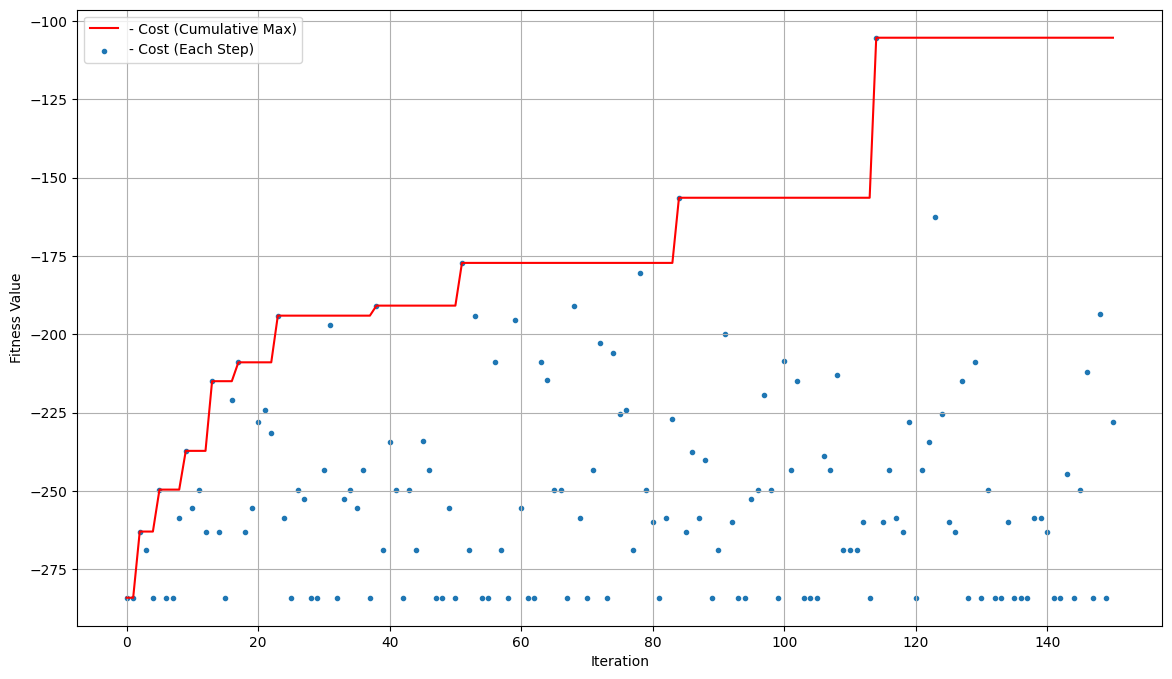

The solution is valid:True, Cost:284.0492127923681, Best Solution at step: 0


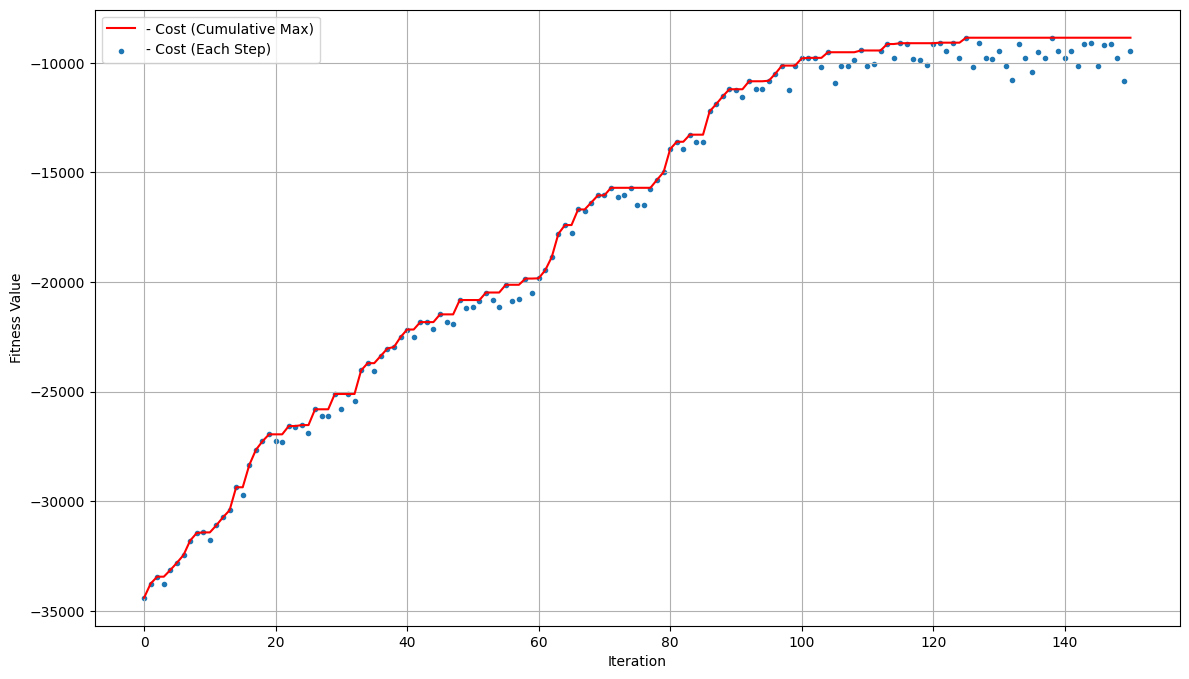

The solution is valid:True, Cost:9444.231012021532, Best Solution at step: 121


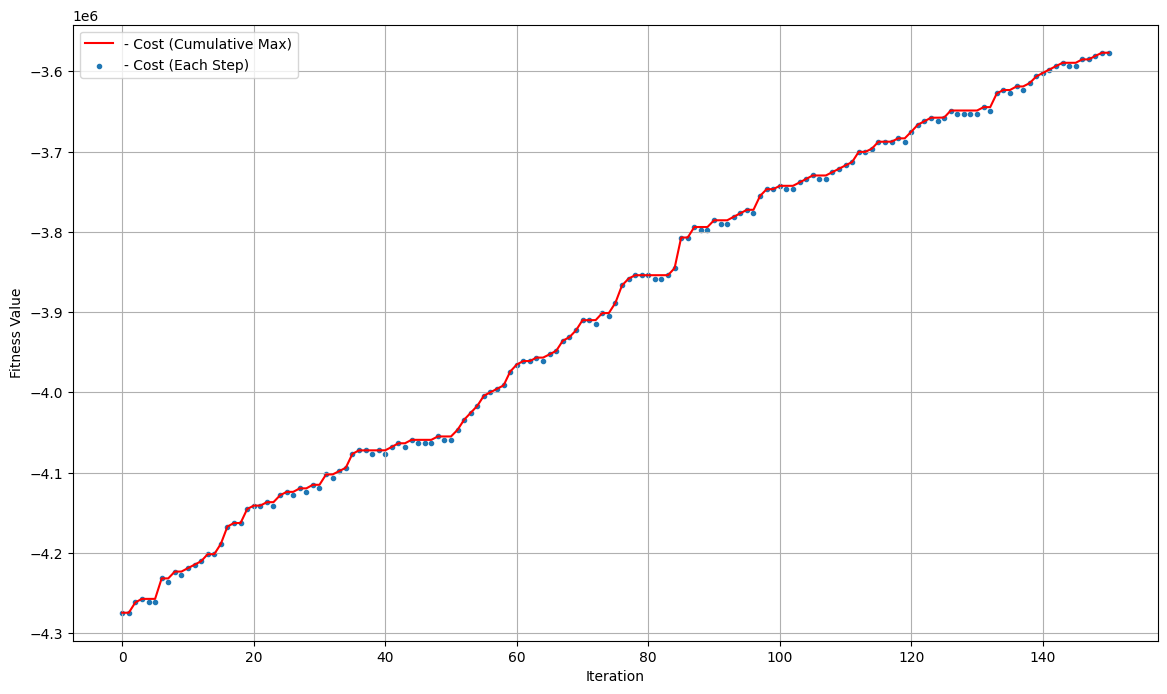

The solution is valid:True, Cost:3576726.4053798574, Best Solution at step: 148


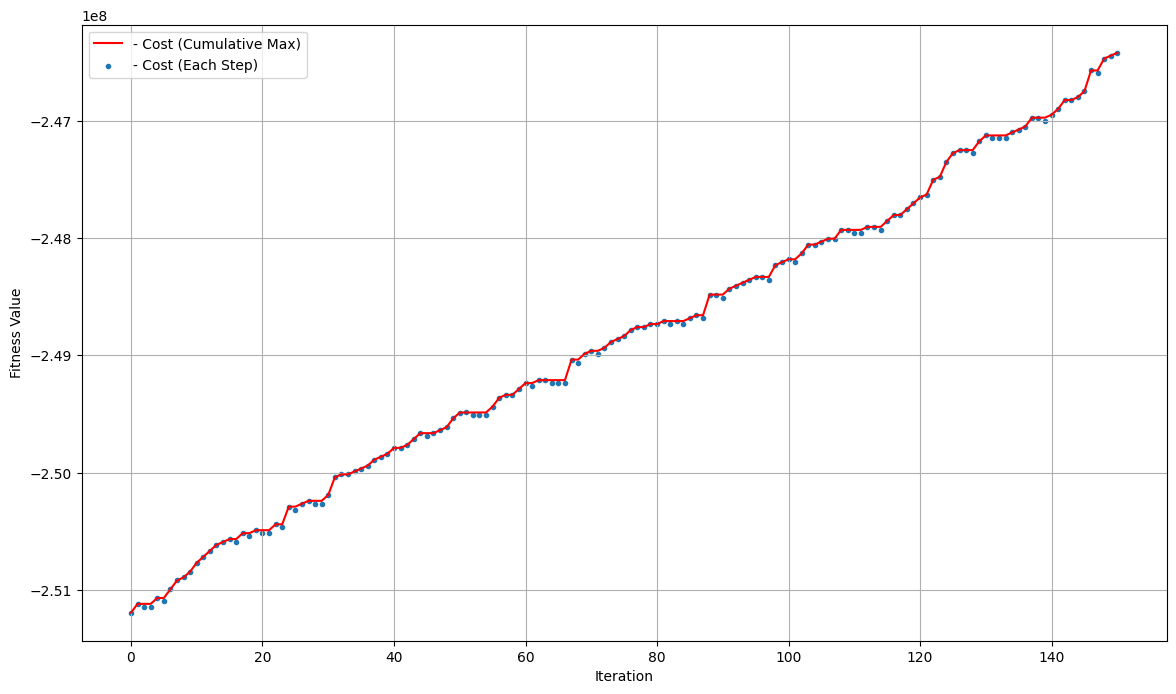

The solution is valid:True, Cost:246417875.09473157, Best Solution at step: 149


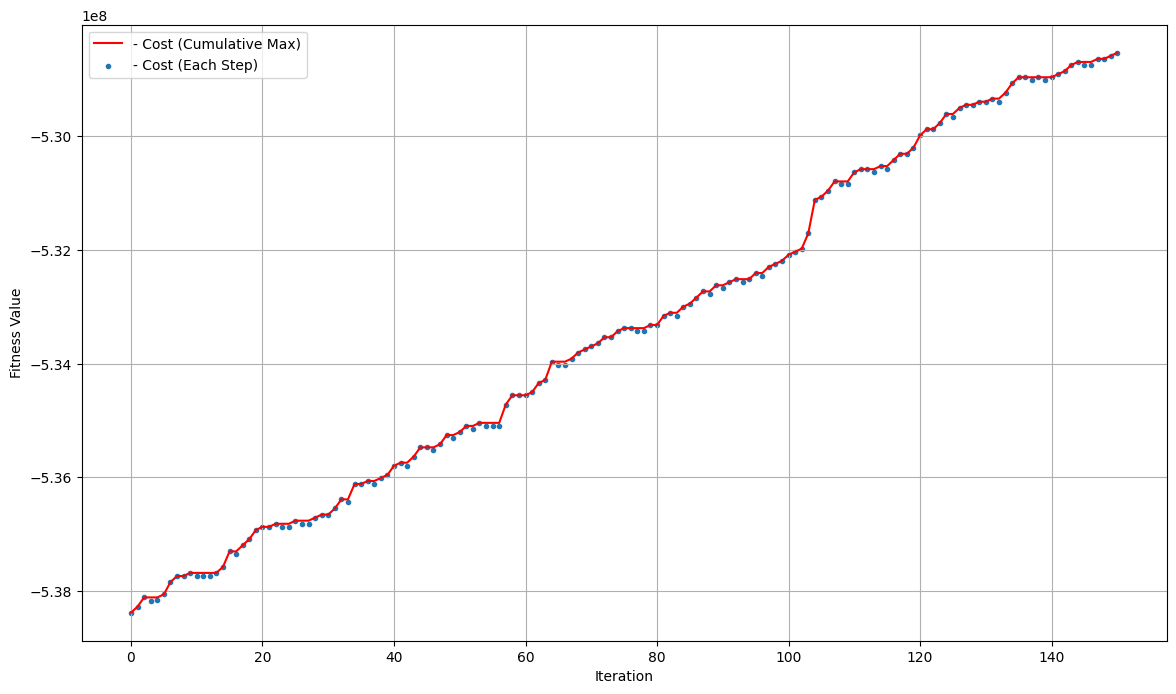

The solution is valid:True, Cost:528529712.76131785, Best Solution at step: 149


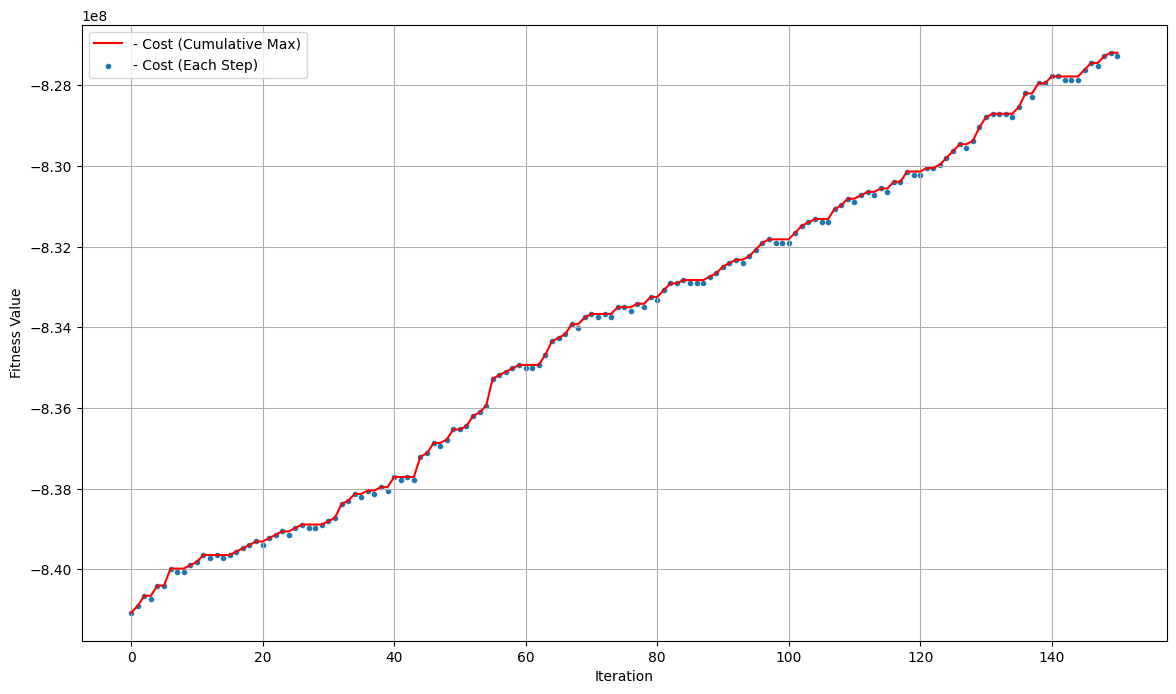

The solution is valid:True, Cost:827187483.4100368, Best Solution at step: 148


In [77]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_costs(universe_size, num_sets, density)
    solution, step = hill_climb_RMHC(tweak_RMHC, starting_point, fitness, plotter)
    print(f"The solution is valid:{valid(solution)}, Cost:{cost(solution)}, Best Solution at step: {step}")


Analyzing the set cover Problem and the instances given, we can say that hill climbing algorithm is not the best solution for the instances. In fact, the cost for the biggest instance is too much, the algorithm will be fine for little instance.

### Simulated Annealing

I will try to find an acceptable solution with the simulated annealing. This algorithm is better than the HC about accepting worst solution.  

In [103]:
INITIAL_TEMPERATURE = 1000  #Controls the probability of accepting worst solution than the actual solution
COOLING_RATE = 0.996        #Controls the speed of the temperature reduction during the process

#So bigger is the cooling rate faster the temperature will decrease -> the algorithm will stop to accept wors solution, it will look like a local search
#Lower is the cooling rate slower the temperature will decrease -> the algorithm may explore too much the space

def simulated_annealing(tweak, sP, fit, plot, penalty_weight=1e5):
   
   #first steps of SA -> initializing solution and other parameters 
    first_solution = sP()  
    best_solution = first_solution.copy() 
    current_fitness = fit(first_solution)
    current_items, current_cost = current_fitness

    temperature = INITIAL_TEMPERATURE
    current_penalty = penalty_weight * (not valid(first_solution)) ** 2
    current_fitness = (current_fitness[0]-current_penalty, current_fitness[1]-current_penalty)
    history = [(current_items, current_cost)]
    
    best_step = 0
    iteration = 0
    
    while temperature > 1e-10:  
        #At every step we will compute the new solution with his fitness  
        new_solution = tweak(first_solution.copy())  #R
        new_fitness = fit(new_solution) 
        new_items, new_cost = new_fitness  
        new_penalty = penalty_weight * (not valid(new_solution))
        new_fitness = (new_items-new_penalty, new_cost-new_penalty)
        
        #Measuring the distance for the acceptability of the solution
        euclidian_distance = np.linalg.norm(np.array(new_fitness) - np.array(current_fitness))

        if (euclidian_distance > 0 ) or (rng.random() < math.exp( euclidian_distance / temperature)):
            first_solution = new_solution
            current_items, current_cost = new_items, new_cost 
            history.append((current_items, current_cost))  
            
            
            if new_fitness > fit(best_solution) and valid(new_solution): 
                best_solution = first_solution.copy() 
                best_step = iteration

        #temperature reduction
        temperature *= COOLING_RATE
       
        iteration +=1
   
    plot(history)
    return best_solution, best_step 

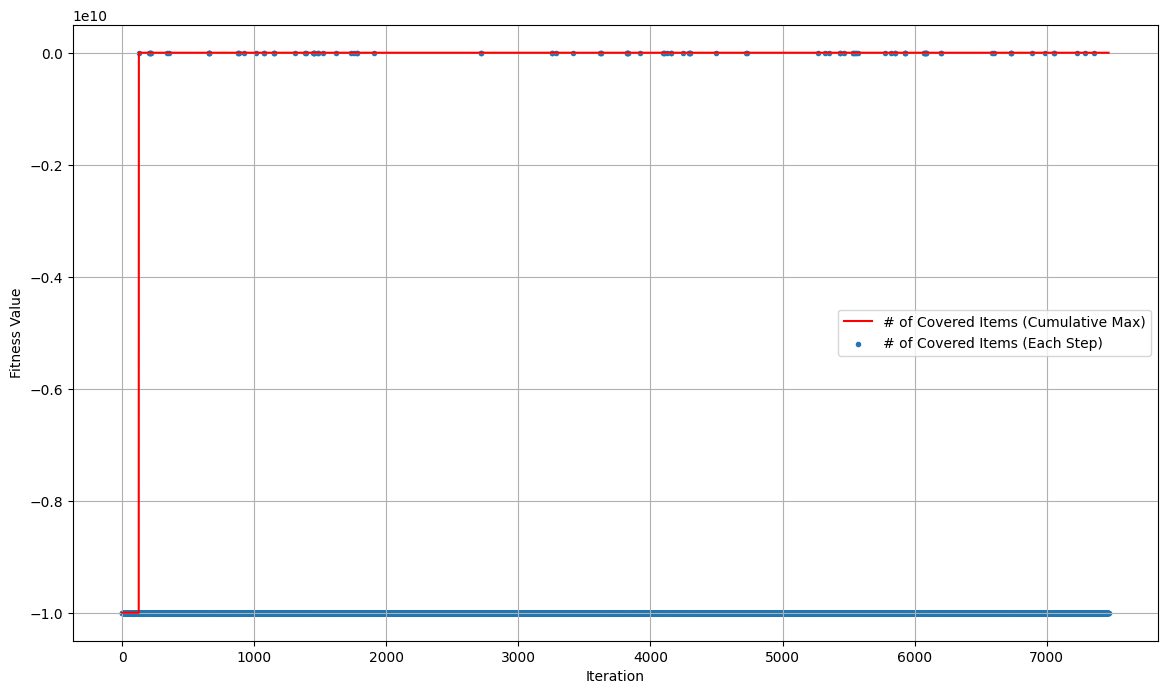

The solution is valid:True, Cost:284.0492127923681, Best Solution at step: 125


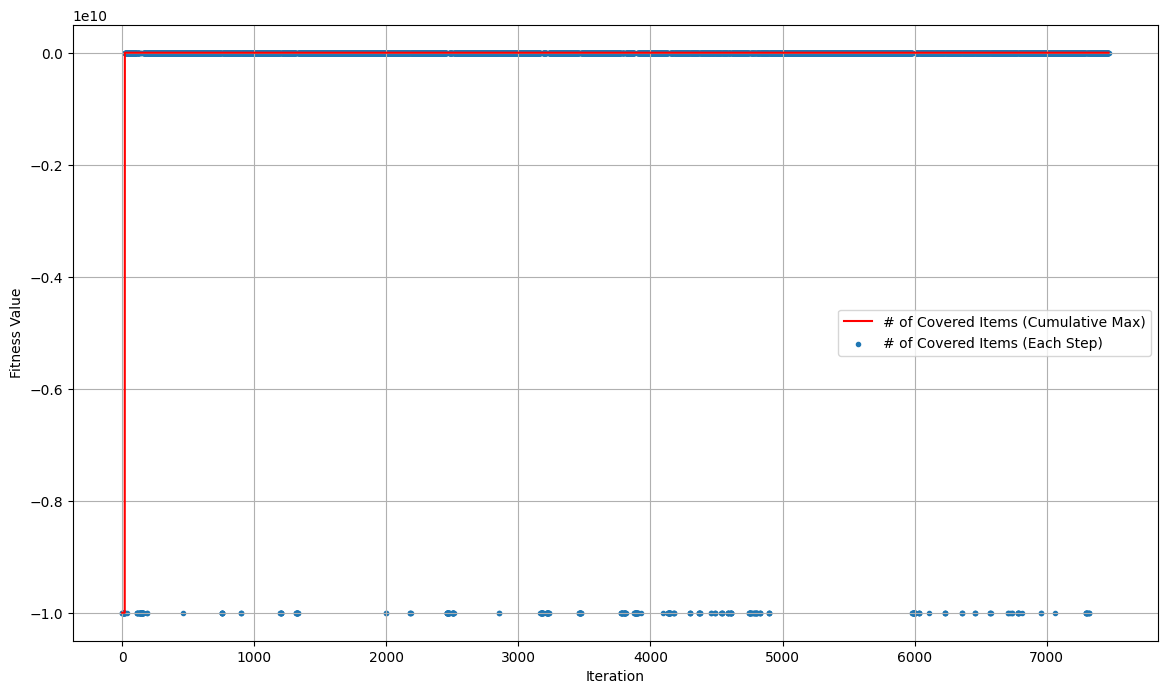

The solution is valid:True, Cost:10064.029523400886, Best Solution at step: 30


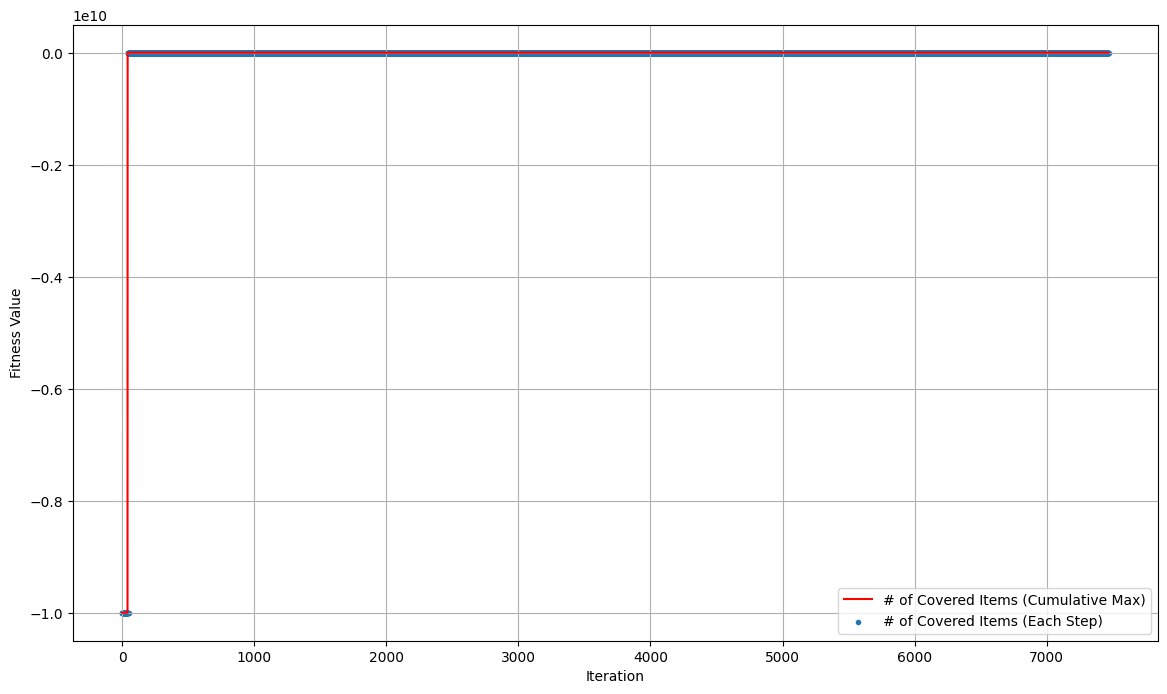

The solution is valid:True, Cost:185890.90656508916, Best Solution at step: 40


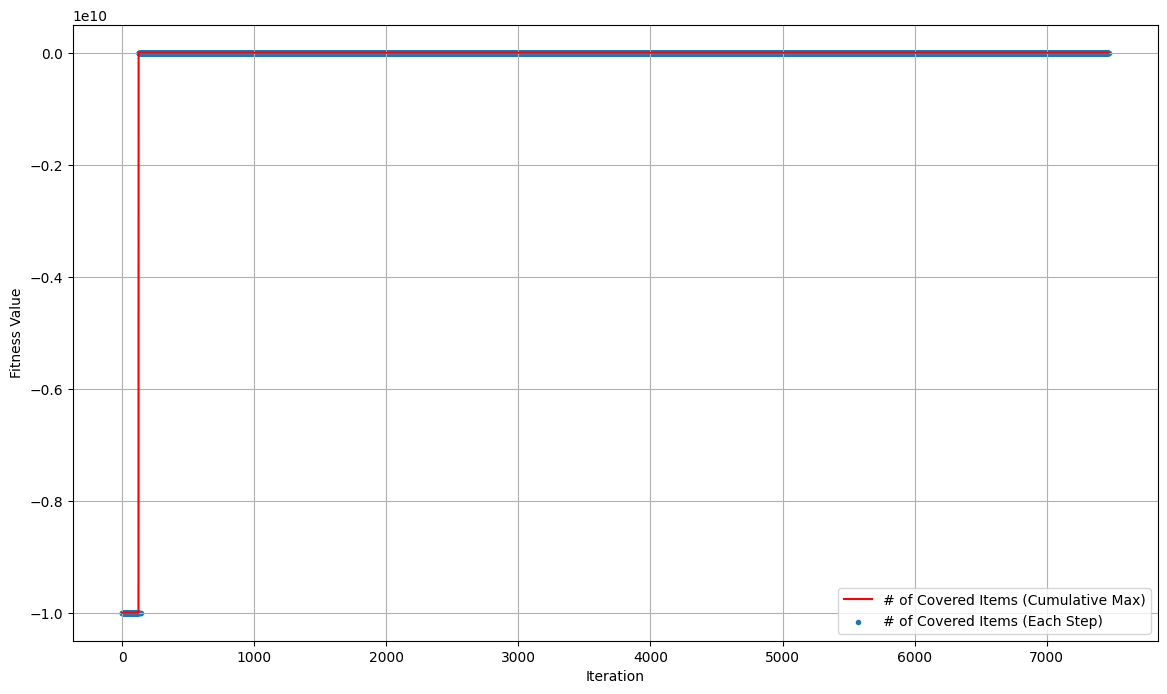

The solution is valid:True, Cost:2661755.500733458, Best Solution at step: 123


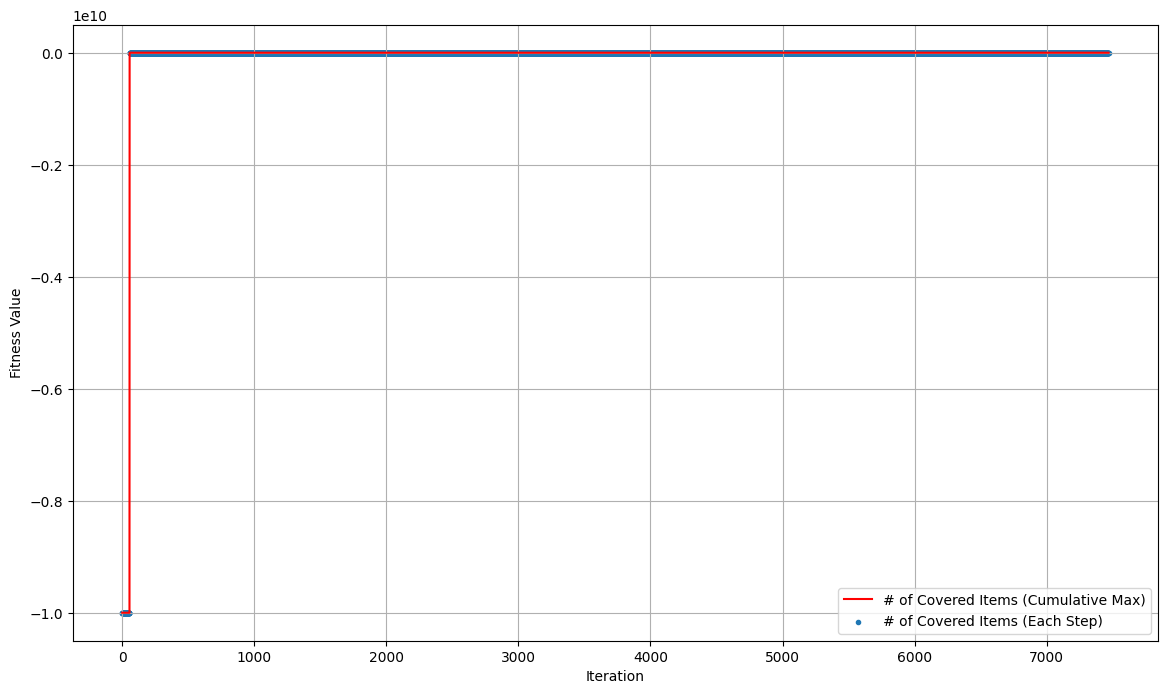

The solution is valid:True, Cost:3012262.2720628926, Best Solution at step: 57


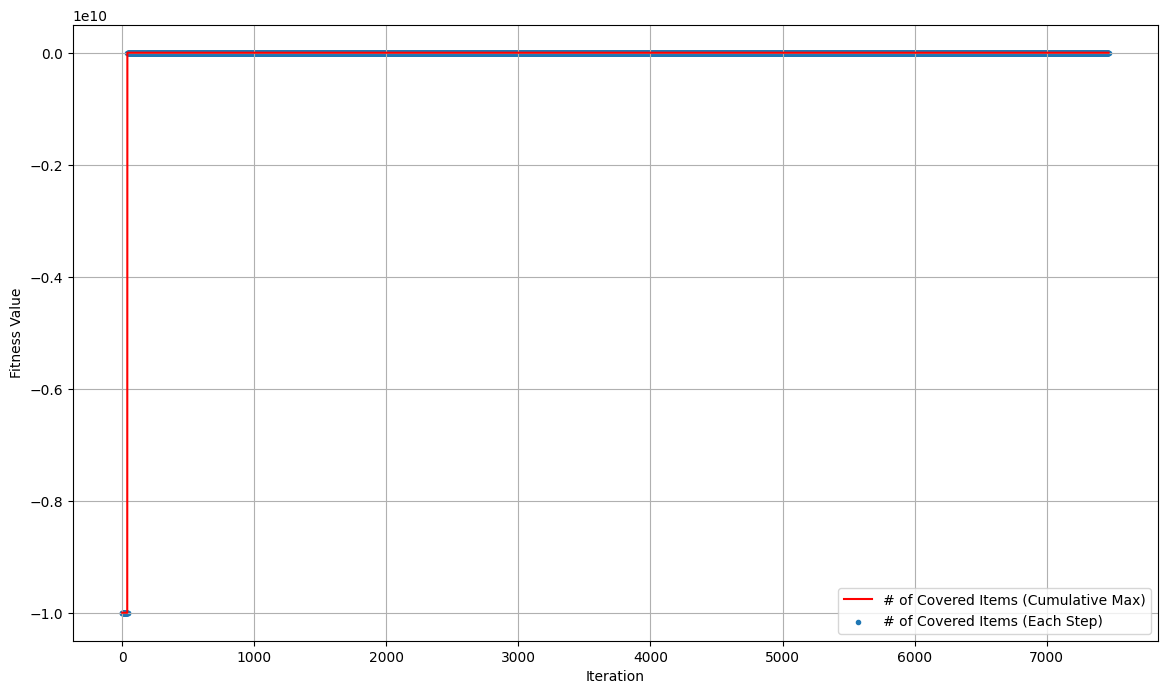

The solution is valid:True, Cost:2606198.3394716918, Best Solution at step: 38


In [104]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_costs(universe_size, num_sets, density)
    solution, step  = simulated_annealing(tweak_RMHC, starting_point_2, fitness_improved, plotter2)
    print(f"The solution is valid:{valid(solution)}, Cost:{cost(solution)}, Best Solution at step: {step}")

Concluding, with Simulated Annealing is an acceptable solution for not too big instance. 